
Number of samples in the traffic training dataset: 5820
Example information:
Image shape: (224, 224, 3)
Bounding boxes: [[403, 313, 421, 346]]
Labels: ['Intersection with priority']


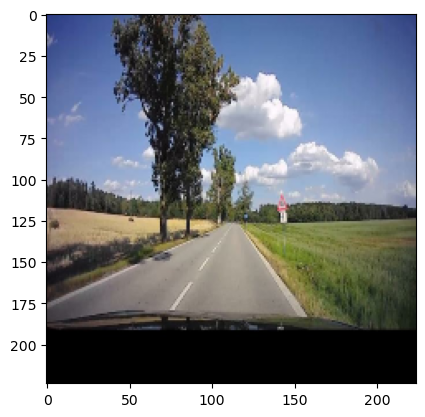

Number of samples in the traffic training dataset: 5820
Example information:
Image shape: (224, 224, 3)
Bounding boxes: [[1, 1, 641, 641]]
Labels: ['Priority road']


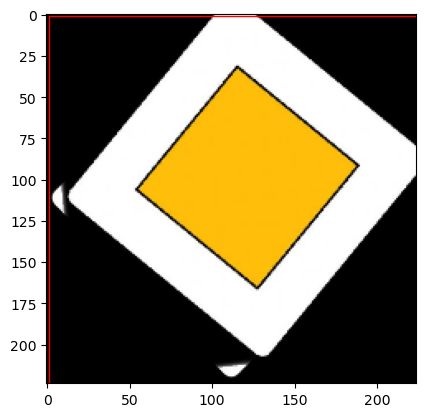

Number of samples in the traffic training dataset: 5820
Example information:
Image shape: (224, 224, 3)
Bounding boxes: [[344, 307, 363, 333]]
Labels: ['Entering city']


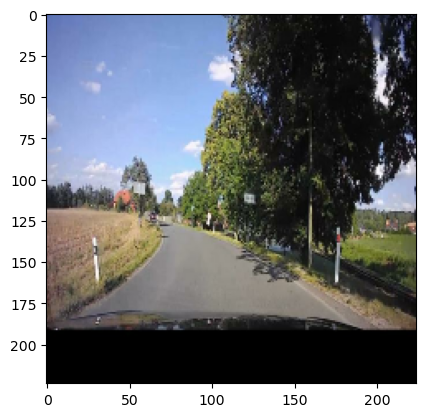

Number of samples in the traffic training dataset: 5820
Example information:
Image shape: (224, 224, 3)
Bounding boxes: [[262, 105, 384, 447]]
Labels: ['Green light']


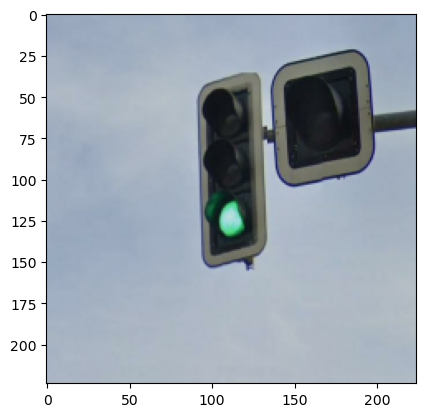

Number of samples in the traffic training dataset: 5820
Example information:
Image shape: (224, 224, 3)
Bounding boxes: [[1, 1, 641, 641]]
Labels: ['Right curve']


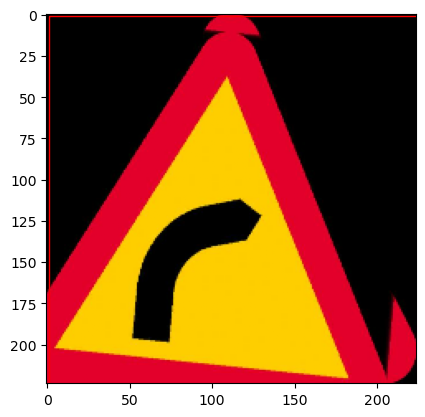




Epoch 1/10


182/182 [==============================] - 2277s 9s/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 7.7358e-06 - val_accuracy: 1.0000
Epoch 2/10
182/182 [==============================] - 1397s 8s/step - loss: 7.6965e-06 - accuracy: 1.0000 - val_loss: 2.0765e-04 - val_accuracy: 1.0000
Epoch 3/10
 32/182 [====>.........................] - ETA: 34:48 - loss: 7.3671e-06 - accuracy: 1.0000

In [ ]:
import tensorflow as tf
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers

# Define the function to parse XML annotations
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels

def load_dataset(image_dir, annotation_dir):
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    annotation_paths = [os.path.join(annotation_dir, filename) for filename in os.listdir(annotation_dir) if filename.endswith('.xml')]

    dataset = []

    for annotation_path in annotation_paths:
        image_filename = os.path.basename(annotation_path).replace('.xml', '.jpg')
        image_path = os.path.join(image_dir, image_filename)

        if image_path in image_paths:
            boxes, labels = parse_annotation(annotation_path)
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, (224, 224))  # Adjust size as needed

            dataset.append((image, (boxes, labels)))

    return dataset

# Define the function to load and preprocess the dataset
def load_and_preprocess_dataset(base_dir, class_name):
    image_dir = os.path.join(base_dir, class_name)
    train_dir = os.path.join(image_dir, "train")
    test_dir = os.path.join(image_dir, "test")

    # Define a function for image and label preprocessing
    def preprocess_image(image, size=(224, 224)):
        # Resize the image to the specified size
        image = tf.image.resize(image, size)
        # Normalize pixel values to be in the range [0, 1]
        image = image / 255.0
        return image

    def preprocess_labels(labels):
        # Convert labels to numerical format if needed
        # For binary classification (fire or no fire), you may not need this step
        return labels
    
    # Load the training dataset
    train_dataset = load_dataset(train_dir, train_dir)

    # Preprocess the training dataset
    train_dataset = [(preprocess_image(image), {"boxes": boxes, "labels": preprocess_labels(labels)}) for image, (boxes, labels) in train_dataset]

    # Load the test dataset
    test_dataset = load_dataset(test_dir, test_dir)

    # Preprocess the test dataset
    test_dataset = [(preprocess_image(image), {"boxes": boxes, "labels": preprocess_labels(labels)}) for image, (boxes, labels) in test_dataset]

    return train_dataset, test_dataset

# Replace this path with the actual path to your labeled dataset
base_dataset_dir = r'C:\Users\Bhargav\Documents\Traffic Detection'

# Load and preprocess the "fire" class dataset
Traffic_train_dataset, Traffic_test_dataset = load_and_preprocess_dataset(base_dataset_dir, "Traffic")

# Load and preprocess the "no_fire" class dataset
#no_fire_train_dataset, no_fire_test_dataset = load_and_preprocess_dataset(base_dataset_dir, "no fire")

num_samples_to_visualize = 5

# Get a list of unique random indices
unique_random_indices = random.sample(range(len(Traffic_train_dataset)), num_samples_to_visualize)

for random_index in unique_random_indices:
    print("Number of samples in the traffic training dataset:", len(Traffic_train_dataset))
    print("Example information:")
    print("Image shape:", Traffic_train_dataset[random_index][0].shape)
    print("Bounding boxes:", Traffic_train_dataset[random_index][1]["boxes"])
    print("Labels:", Traffic_train_dataset[random_index][1]["labels"])

    # Visualize a sample image
    sample_image = Traffic_train_dataset[random_index][0].numpy()
    sample_boxes = Traffic_train_dataset[random_index][1]["boxes"]

    plt.imshow(sample_image)

    for box in sample_boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.show()
    
    import time
    time.sleep(1)


# EfficientDet Backbone
eff_backbone = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Custom Head
model_head = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Combine the EfficientDet backbone with the custom head
full_model = tf.keras.Sequential([
    eff_backbone,
    model_head
])

# Compile the model
full_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([image for image, _ in Traffic_train_dataset], [1] * len(Traffic_train_dataset))
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ([image for image, _ in Traffic_test_dataset], [1] * len(Traffic_test_dataset))
)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Train the model
full_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Print test accuracy
test_loss, test_accuracy = full_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
full_model.save(r"C:\Users\Bhargav\Documents\Traffic_Detection_Model\traffic_sign_model.h5")

# Save the datasets
tf.data.experimental.save(train_dataset, r"C:\Users\Bhargav\Documents\Traffic_Detection_Model\train_dataset")
tf.data.experimental.save(test_dataset, r"C:\Users\Bhargav\Documents\Traffic_Detection_Model\test_dataset")